# Sistema de recomendacion de Anime basado en contenido

### Integrantes : 
-  Verónica Martinez
- Alejandra Aravena
- Hugo Zuñiga
- Cesar Flores

In [107]:
#importar librerias
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns 
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import MaxAbsScaler
from numpy import random

In [108]:
# Cargamos la base de datos y realizamos algunas exploraciones

In [109]:
df_anime = pd.read_csv("Anime.csv", sep=';', decimal=',')
df_ratings = pd.read_csv("rating.csv")

In [110]:
df_anime.shape
#veamos numeros de filas y columnas 

(12294, 7)

In [111]:
df_ratings.shape
#veamos numeros de filas y columnas 

(7813737, 3)

In [112]:
df_ratings.info()
# informacion de las variables

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7813737 entries, 0 to 7813736
Data columns (total 3 columns):
user_id     int64
anime_id    int64
rating      int64
dtypes: int64(3)
memory usage: 178.8 MB


In [113]:
df_ratings.head()

user_id  anime_id  rating
0        1        20      -1
1        1        24      -1
2        1        79      -1
3        1       226      -1
4        1       241      -1

In [114]:
#Segun info otorgada el -1 corresponde a anime que no tiene valoracion por parte del usuario

In [115]:
df_anime.info()
#Info 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12294 entries, 0 to 12293
Data columns (total 7 columns):
anime_id    12294 non-null int64
name        12294 non-null object
genre       12247 non-null object
type        12269 non-null object
episodes    12294 non-null object
rating      12064 non-null float64
members     12294 non-null int64
dtypes: float64(1), int64(2), object(4)
memory usage: 672.4+ KB


In [116]:
n_users = df_ratings.user_id.unique().shape[0]
n_users
# cantidad de usuarios

73515

In [117]:
n__users = df_ratings.user_id.unique().shape[0] #cantidad usuarios
n__items = df_ratings.anime_id.unique().shape[0]# cantidad anime
print (str(n__users) + ' users')
print (str(n__items) + ' items')

73515 users
11200 items


In [118]:
#Empezamos con la modelacion
##buscamos valores nulos en las columnas genero, tipo y ratings

In [119]:
df_anime[df_anime['genre'].isnull()].sort_values('members', ascending = False).sample(5)

anime_id                    name genre   type episodes  rating  members
8766     30861            Happy Bogeys   NaN  Movie       12    8.17       38
8565     29923                Fukusuke   NaN  Movie        1    4.69      103
9171     28691   Kemurigusa Monogatari   NaN  Movie        1    7.33       56
6040     29765       Metropolis (2009)   NaN  Movie        1    6.27      313
8279     29921  Bunbuku Chagama (1958)   NaN  Movie        1    5.52       86

In [120]:
df_anime[df_anime['type'].isnull()].sort_values('members', ascending = False).sample(5)

anime_id                           name                         genre  \
12252     34382                         Citrus  Drama, Romance, School, Yuri   
11010     33899                       IDOLiSH7                 Music, Shoujo   
11041     30448                    Mirai Arise                        Sci-Fi   
10949     33475  Busou Shoujo Machiavellianism       Action, School, Shounen   
11058     24023                     Project758                         Drama   

      type episodes  rating  members  
12252  NaN  Unknown     NaN     2459  
11010  NaN  Unknown     NaN     1048  
11041  NaN  Unknown     NaN     4044  
10949  NaN  Unknown     NaN     1896  
11058  NaN  Unknown     NaN      455

In [121]:
df_anime[df_anime['rating'].isnull()].sort_values('members', ascending = False).sample(5)

anime_id                                      name  \
12265     34361                  Kyonyuu Reijou MC Gakuen   
11029     31812  Kuroshitsuji Movie: Book of the Atlantic   
10985     33203                          Fukumenkei Noise   
11049     34148                               Nyanko Days   
11010     33899                                  IDOLiSH7   

                                                   genre   type episodes  \
12265                                             Hentai    OVA  Unknown   
11029  Action, Comedy, Demons, Fantasy, Historical, S...  Movie        1   
10985                             Music, Romance, Shoujo     TV  Unknown   
11049                              Comedy, Slice of Life     TV  Unknown   
11010                                      Music, Shoujo    NaN  Unknown   

       rating  members  
12265     NaN      205  
11029     NaN    20335  
10985     NaN     2127  
11049     NaN     1335  
11010     NaN     1048

- Valores vacios en Genero : No podemos rellenar pues no sabemos la data
- Valores vacios en Tipo:  No podemos rellenar pues no sabemos la data
- Valores vacios en Ranking : Serán rellenados (con media o promedio u otro)

In [122]:
df_anime = df_anime.replace('Unknown', np.nan) # reemplazo desconocido por nan 
df_anime = df_anime.dropna(how = 'all') # eliminamos datos nan
df_anime['episodes'] = df_anime['episodes'].map(lambda x:np.nan if pd.isnull(x) else int(x))
df_ratings = df_ratings.replace(-1, np.nan)

In [123]:
#Evaluemos distribucion

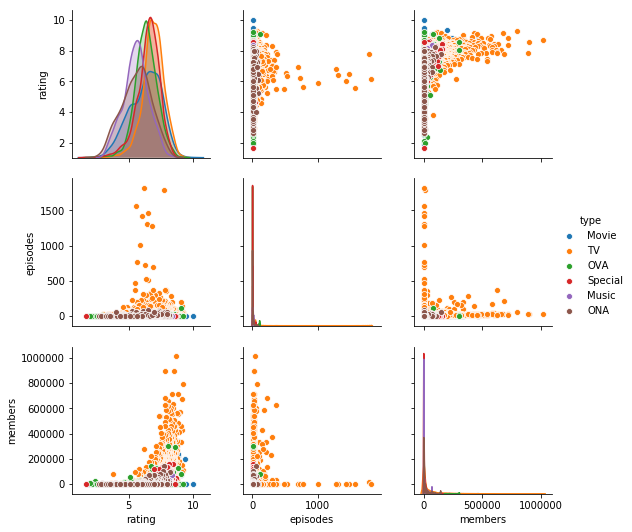

In [124]:
sns.pairplot(data=df_anime[['type','rating','episodes','members']].dropna(),hue='type')

- La distribución de los ratings es __Leptocúrtica__ ---->  es decir existe una gran concentración de los valores en torno a su media, con mayor presencia entre los ranking 5 y 8 (y algunos ouliers)
- En base a ello llenaremos los valores faltantes usando la MEDIANA de los rating 

(array([2.300e+02, 2.000e+00, 2.200e+01, 2.110e+02, 7.520e+02, 2.372e+03,
        4.784e+03, 3.294e+03, 6.030e+02, 2.400e+01]),
 array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10.]),
 <a list of 10 Patch objects>)

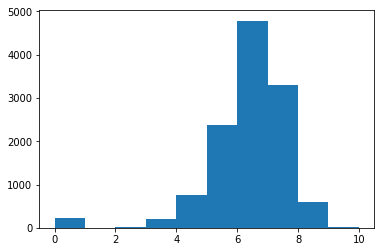

In [125]:
plt.hist(df_anime['rating'].fillna(0))

In [126]:
# rellenamos nan con la media 
df_anime['rating'] =df_anime['rating'].fillna(df_anime.rating.median())

(array([   6.,   49.,  275.,  733., 1824., 3884., 3822., 1467.,  225.,
           9.]),
 array([ 1.67 ,  2.503,  3.336,  4.169,  5.002,  5.835,  6.668,  7.501,
         8.334,  9.167, 10.   ]),
 <a list of 10 Patch objects>)

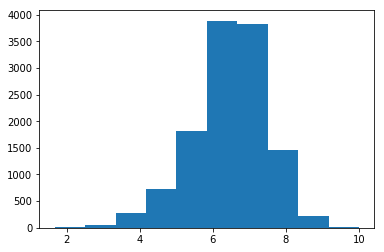

In [127]:
plt.hist(df_anime['rating'].fillna(0))

In [128]:
# es posible ver el cambio en la distribucion

In [129]:
# Veamos especificamente cuantas valoraciones existen

pd.DataFrame(df_ratings.groupby('rating').user_id.count()).reset_index()

rating  user_id
0     1.0    16649
1     2.0    23150
2     3.0    41453
3     4.0   104291
4     5.0   282806
5     6.0   637775
6     7.0  1375287
7     8.0  1646019
8     9.0  1254096
9    10.0   955715

In [130]:
df_ratings.count() #hay datos perdidos en rating 

user_id     7813737
anime_id    7813737
rating      6337241
dtype: int64

In [131]:
# selección de animes que tengan cantidad de rating superior a 80 para hacer mas rapida la consulta
# para ello explorar distribucion x tipo

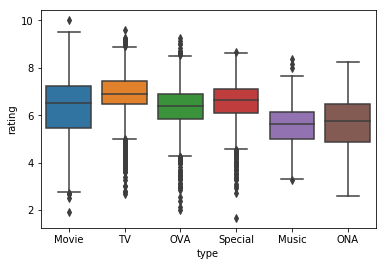

In [132]:
sns.boxplot(data = df_anime, y = 'rating', x='type')

__Priorizamos catogorizar por genero. Tambien cuantos usser han visto cada anime__

(array([1.0675e+04, 3.4500e+02, 1.0000e+02, 4.5000e+01, 1.7000e+01,
        7.0000e+00, 7.0000e+00, 3.0000e+00, 0.0000e+00, 1.0000e+00]),
 array([1.00000e+00, 3.93490e+03, 7.86880e+03, 1.18027e+04, 1.57366e+04,
        1.96705e+04, 2.36044e+04, 2.75383e+04, 3.14722e+04, 3.54061e+04,
        3.93400e+04]),
 <a list of 10 Patch objects>)

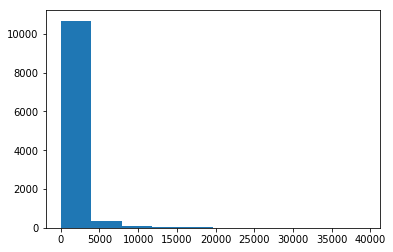

In [133]:
plt.hist(df_ratings.groupby(['anime_id'])['anime_id'].count())

Existe un sesgo, pues recomendara las series mas vistas sobre las menos vistas (Ver grafico)

La informacion del dataset establese que las serie  series sin rating no han sido evaluadas ya que no se encuentran aun en emision o no han sido lanzadas, por lo que trataremos que nuestro sistema tambien sea capaz de recomendarlas.

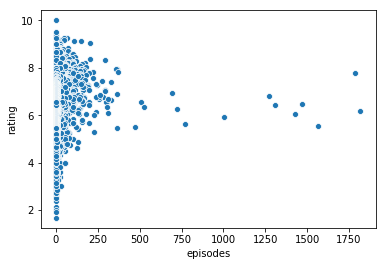

In [134]:
sns.scatterplot( x = df_anime['episodes'], y= df_anime['rating'])

Se prefiere anime con menor cantidad de episodios

## Representaciones Matriciales

* Unimos los datasets para extraer subsets de entrenamiento!

In [135]:
fulldf = pd.merge(df_anime, df_ratings, how = 'right', on ='anime_id', suffixes = ['_avg', '_user'])
fulldf.rename(columns = {'rating_user':'user_rating', 'rating_avg':'avg_rating'}, inplace = True)

In [136]:
fulldf.sample(10)

anime_id                                              name  \
7556746      2476                                       School Days   
2930637     15451                               High School DxD New   
949397       1889                     Higurashi no Naku Koro ni Kai   
6415699       162                                          Pita Ten   
7460946      8491    Digimon Savers 3D: Digital World Kiki Ippatsu!   
1627024      4107      Tengen Toppa Gurren Lagann Movie: Gurren-hen   
7549479     25429                                             Isuca   
721296       6594                                      Katanagatari   
4655100     10178                         Otona Joshi no Anime Time   
5866889     12979  Naruto SD: Rock Lee no Seishun Full-Power Ninden   

                                                     genre     type  episodes  \
7556746                      Drama, Harem, Romance, School       TV      12.0   
2930637  Action, Comedy, Demons, Ecchi, Harem, Romance,...       TV      12.0   
949397      Mystery, Psychological, Supernatural, Thriller       TV      24.0   
6415699    Comedy, Fantasy, Kids, Romance, School, Shounen       TV      26.0   
7460946     Action, Adventure, Fantasy, Kids, Supernatural    Movie       1.0   
1627024                              Action, Comedy, Mecha    Movie       1.0   
7549479  Action, Comedy, Ecchi, Romance, School, Seinen...       TV      10.0   
721296   Action, Adventure, Historical, Martial Arts, R...       TV      12.0   
4655100                        Drama, Josei, Slice of Life  Special       4.0   
5866889                             Action, Comedy, Parody       TV      51.0   

         avg_rating   members  user_id  user_rating  
7556746        6.17  279183.0    33068          8.0  
2930637        7.87  266657.0    27273          8.0  
949397         8.41  218101.0    59245          9.0  
6415699        7.08   16047.0    41574          6.0  
7460946        6.35    3720.0    22910          3.0  
1627024        8.22   72933.0    58448         10.0  
7549479        6.17   63638.0    71032          6.0  
721296         8.49  207241.0    40923          9.0  
4655100        7.52   11268.0    22411          7.0  
5866889        7.26   29989.0     4037         10.0

In [137]:
df_genres_list = df_anime['genre'].str.get_dummies(sep = ', ')

## Para el filtro de Contenido

In [138]:
df_genres_list.sample(10)

Action  Adventure  Cars  Comedy  Dark Fantasy  Dementia  Demons  Drama  \
6210        0          0     0       1             0         0       0      1   
4671        1          1     0       0             0         0       0      0   
8495        0          0     0       0             0         0       0      1   
188         0          0     0       1             0         0       0      1   
102         0          0     0       0             0         0       0      1   
10468       0          0     0       1             0         0       0      0   
5108        1          0     0       0             0         0       0      0   
11639       0          0     0       0             0         0       0      0   
10253       1          0     0       0             0         0       0      0   
4138        0          0     0       0             0         0       0      0   

       Ecchi  Fantasy  ...  Shounen Ai  Slice of Life  Space  Sports  \
6210       0        0  ...           0              0      0       0   
4671       0        0  ...           0              0      0       0   
8495       0        0  ...           0              0      0       1   
188        0        0  ...           0              0      0       1   
102        0        0  ...           0              0      0       0   
10468      0        0  ...           0              1      0       0   
5108       0        0  ...           0              0      1       0   
11639      0        0  ...           0              0      0       0   
10253      0        0  ...           0              0      0       0   
4138       0        1  ...           0              0      0       0   

       Super Power  Supernatural  Thriller  Vampire  Yaoi  Yuri  
6210             0             0         0        0     0     0  
4671             0             0         0        0     0     0  
8495             0             0         0        0     0     0  
188              0             0         0        0     0     0  
102              0             0         1        0     0     0  
10468            0             0         0        0     0     0  
5108             0             0         0        0     0     0  
11639            0             0         0        0     0     0  
10253            0             0         0        0     0     0  
4138             0             0         0        0     0     0  

[10 rows x 46 columns]

In [139]:
df_types_list = pd.get_dummies(df_anime[["type"]])
df_types_list.sample(10)

type_Movie  type_Music  type_ONA  type_OVA  type_Special  type_TV
4378            0           0         0         0             0        1
12273           0           0         0         1             0        0
10789           1           0         0         0             0        0
10186           1           0         0         0             0        0
9439            1           0         0         0             0        0
3535            0           0         0         1             0        0
86              0           0         0         0             0        1
8648            0           0         0         1             0        0
6661            0           0         0         1             0        0
11996           0           0         0         1             0        0

In [140]:
#crear el dataset de entrenamiento final para contenido
df_feat = df_anime[['members','rating','episodes']]
df_features = pd.concat([df_feat,df_genres_list, df_types_list], axis = 1).fillna(0)

In [141]:
df_features.head()

members  rating  episodes  Action  Adventure  Cars  Comedy  Dark Fantasy  \
0   200630    9.37       1.0       0          0     0       0             0   
1   793665    9.26      64.0       1          1     0       0             0   
2   114262    9.25      51.0       1          0     0       1             0   
3   673572    9.17      24.0       0          0     0       0             0   
4   151266    9.16      51.0       1          0     0       1             0   

   Dementia  Demons  ...  Thriller  Vampire  Yaoi  Yuri  type_Movie  \
0         0       0  ...         0        0     0     0           1   
1         0       0  ...         0        0     0     0           0   
2         0       0  ...         0        0     0     0           0   
3         0       0  ...         1        0     0     0           0   
4         0       0  ...         0        0     0     0           0   

   type_Music  type_ONA  type_OVA  type_Special  type_TV  
0           0         0         0             0        0  
1           0         0         0             0        1  
2           0         0         0             0        1  
3           0         0         0             0        1  
4           0         0         0             0        1  

[5 rows x 55 columns]

In [142]:
#funciones de Apoyo

In [143]:
def get_nombre_from_index(index):
    return df_anime[df_anime.index == index]['name'].values[0]
def get_id_from_nombre(name):
    return df_anime[df_anime.name == name]['anime_id'].values[0]
def get_index_from_id(anime_id):
    return df_anime[df_anime.anime_id == anime_id].index.values[0]

In [144]:
#Obtendremos el promedio de las valoraciones que el usuario ha dado a las series para determinar si le gustan
# recomendaremos series similares a sus favoritas o mejor valoradas.
## Consideraremos el valor promedio de las series que el usuario haya evaluado
def get_user_top_list(user):
    df_user = df_ratings[df_ratings['user_id']==user]
    df_rated = df_user.dropna(how = 'any')
    avg =  df_rated.rating.mean() 
    df_toplist = df_rated[df_rated['rating']>= avg].sort_values('rating', ascending = False).head(10)
    return list(df_toplist['anime_id'])
def get_user_viewed_list(user):
    return list(df_ratings[df_ratings['user_id']==user]['anime_id'])

## Modelado por KNN (Contenido)

* Se usa k = K+1 siendo K el numero de recomendaciones que se desea obtener, ya que la primera siempre es el mismo dato
* Como tenemos variables dummy binarias vs variables con valor muy alto (episodios, miembros) se utilizara  la biblioteca MaxAbsScaler para convertir dichos valores en una distribucion 0-1. Equivale a normalizar con funcion Z

In [145]:
mas = MaxAbsScaler()
df_features2 = mas.fit_transform(df_features)

In [146]:
k = 15

In [147]:
neighbors_content = NearestNeighbors(n_neighbors = k, algorithm = 'ball_tree')

In [148]:
neighbors_content

NearestNeighbors(algorithm='ball_tree', leaf_size=30, metric='minkowski',
                 metric_params=None, n_jobs=None, n_neighbors=15, p=2,
                 radius=1.0)

In [149]:
neighbors_content.fit(df_features2)
# entrenamos 

NearestNeighbors(algorithm='ball_tree', leaf_size=30, metric='minkowski',
                 metric_params=None, n_jobs=None, n_neighbors=15, p=2,
                 radius=1.0)

In [150]:
distances, indices = neighbors_content.kneighbors(df_features2)

In [151]:
distances.shape

(12294, 15)

In [152]:
indices.shape

(12294, 15)

In [153]:
def get_recommendations(aid):
    anime =  get_index_from_id(aid)
    test = list(indices2[anime,1:11])
    nb = []
    for i in test:
        a_name = get_nombre_from_index(i)
        nb.append(a_name)
    return nb

### Ver comparacion entre la recomendacion y la serie

* Extraer las series que el usuario ya haya visto

In [154]:
get_user_top_list(73509)

[199]

In [155]:
get_recommendations(23283)

['Re:Zero kara Hajimeru Isekai Seikatsu',
 'Mahou Shoujo Madoka★Magica',
 'Higurashi no Naku Koro ni Kai',
 'Gyakkyou Burai Kaiji: Ultimate Survivor',
 'Selector Infected WIXOSS',
 'Gyakkyou Burai Kaiji: Hakairoku-hen',
 'Touhai Densetsu Akagi: Yami ni Maiorita Tensai',
 'Selector Spread WIXOSS',
 'Steins;Gate']

* Recomendar series hasta que encontremos n series que el usuario no ha visto

In [156]:
def get_n_recommends(user, n):
    vistas = list(get_user_viewed_list(user))
    liked = list(get_user_top_list(user))
    lista = []
    for i in liked:
        ani = pd.Series(get_recommendations(i))
        recs = np.setdiff1d(ani, vistas) 
        lista.extend(recs)
        if(len(lista) > n):
            lista = lista[:n]
            break
    return lista

* probar para un usuario cualquiera de acuerdo a la lista anterior

In [157]:
get_n_recommends(3,5)

['Bungou Stray Dogs 2nd Season',
 'Higurashi no Naku Koro ni Kai',
 'Jigoku Shoujo',
 'Jigoku Shoujo Futakomori',
 'Jigoku Shoujo Mitsuganae']

In [158]:
get_n_recommends(73509, 10)

['Bakemono no Ko',
 'Da Yu Hai Tang',
 'Jungle Taitei Leo: Hon-o-ji',
 'Mai Mai Shinko to Sennen no Mahou',
 'Marco: Haha wo Tazunete Sanzenri',
 'Momo e no Tegami',
 'Oseam',
 'Shisha no Sho',
 'Tobe! Kujira no Peek']

In [159]:
get_n_recommends(2, 10)

['Area no Kishi',
 'Diamond no Ace',
 'Diamond no Ace: Second Season',
 'Haikyuu!!',
 'Kuroko no Basket 2nd Season',
 'Kuroko no Basket 3rd Season',
 'Teekyuu',
 'Teekyuu 2',
 'Teekyuu 3']

In [160]:
get_n_recommends(5, 10)

['Gintama',
 'Gintama (2017)',
 'Gintama Movie: Shinyaku Benizakura-hen',
 'Gintama&#039;',
 'Gintama&#039;: Enchousen',
 'Gintama: Jump Festa 2014 Special',
 'Gintama: Shinyaku Benizakura-hen',
 'Gintama: Yorinuki Gintama-san on Theater 2D',
 'Gintama°',
 'Danshi Koukousei no Nichijou']

In [161]:
get_n_recommends(8, 1)

['Densetsu no Yuusha no Densetsu']

In [162]:
get_n_recommends(8, 1)

['Densetsu no Yuusha no Densetsu']

In [163]:
get_n_recommends(1, 8)

['11eyes',
 'Akiba&#039;s Trip The Animation',
 'Deadman Wonderland',
 'Devilman',
 'Hakaba Kitarou',
 'Nobunagun',
 'Ookamikakushi',
 'Shikabane Hime: Kuro']

In [164]:
get_n_recommends(10, 5)

['Chain Chronicle: Haecceitas no Hikari',
 'Densetsu no Yuusha no Densetsu',
 'Fairy Tail',
 'Fullmetal Alchemist',
 'Jikuu Tenshou Nazca']

In [165]:
# exporto modelo
import pickle
pickle.dump(neighbors_content, open('Knnanime.sav', 'wb'))

In [166]:
pickle.dump(distances, open('distances.sav', 'wb')) 
pickle.dump(indices, open('indices.sav', 'wb')) 

In [68]:
# load the model from disk
loaded_model = pickle.load(open('Knnanime.sav', 'rb'))
distances2 = pickle.load(open('distances.sav', 'rb'))
indices2 = pickle.load(open('indices.sav', 'rb'))

In [69]:
loaded_model #ver si vargo modelo

NearestNeighbors(algorithm='ball_tree', leaf_size=30, metric='minkowski',
                 metric_params=None, n_jobs=None, n_neighbors=10, p=2,
                 radius=1.0)

In [72]:
indices2.shape
#es correcto

(12294, 10)

In [73]:
distances2.shape
#es correcto

(12294, 10)